<a href="https://www.arduino.cc/"><img src="https://raw.githubusercontent.com/sandeepmistry/aimldevfest-workshop-2019/master/images/Arduino_logo_R_highquality.png" width=200/></a>
# Tiny ML on Arduino
## Classify objects by color tutorial


https://github.com/arduino/ArduinoTensorFlowLiteTutorials/

## Setup Python Environment

The next cell sets up the dependencies in required for the notebook, run it.

In [1]:
# Setup environment
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
%tensorflow_version 2.x
!pip install tensorflow

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Upload Data

1. Open the panel on the left side of Colab by clicking on the __>__
1. Select the Files tab
1. Drag `csv` files from your computer to the tab to upload them into colab.

# Train Neural Network





## Parse and prepare the data

The next cell parses the csv files and transforms them to a format that will be used to train the full connected neural network.



TensorFlow version = 2.15.0

apple class will be output 0 of the classifier
71 samples captured for training with inputs ['Red', 'Green', 'Blue'] 



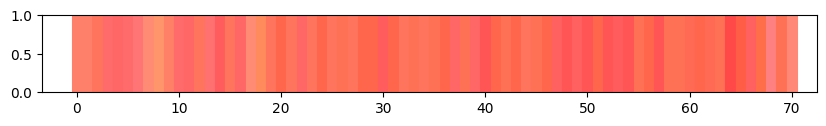

banana class will be output 1 of the classifier
94 samples captured for training with inputs ['Red', 'Green', 'Blue'] 



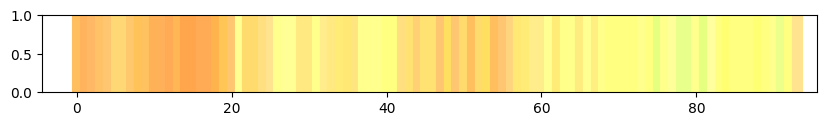

orange class will be output 2 of the classifier
91 samples captured for training with inputs ['Red', 'Green', 'Blue'] 



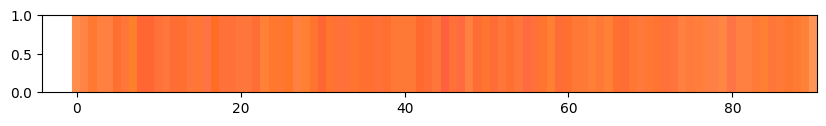

Data set parsing and preparation complete.
Data set randomization and splitting complete.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import fileinput

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

CLASSES = [];

for file in os.listdir("/content/"):
    if file.endswith(".csv"):
        CLASSES.append(os.path.splitext(file)[0])

CLASSES.sort()

SAMPLES_WINDOW_LEN = 1
NUM_CLASSES = len(CLASSES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_CLASSES = np.eye(NUM_CLASSES)

inputs = []
outputs = []

# read each csv file and push an input and output
for class_index in range(NUM_CLASSES):
  objectClass = CLASSES[class_index]
  df = pd.read_csv("/content/" + objectClass + ".csv")
  columns = list(df)
  # get rid of pesky empty value lines of csv which cause NaN inputs to TensorFlow
  df = df.dropna()
  df = df.reset_index(drop=True)

  # calculate the number of objectClass recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_WINDOW_LEN)
  print(f"\u001b[32;4m{objectClass}\u001b[0m class will be output \u001b[32m{class_index}\u001b[0m of the classifier")
  print(f"{num_recordings} samples captured for training with inputs {list(df)} \n")

  # graphing
  plt.rcParams["figure.figsize"] = (10,1)
  pixels = np.array([df['Red'],df['Green'],df['Blue']],float)
  pixels = np.transpose(pixels)
  for i in range(num_recordings):
    plt.axvline(x=i, linewidth=8, color=tuple(pixels[i]/np.max(pixels[i], axis=0)))
  plt.show()

  #tensors
  output = ONE_HOT_ENCODED_CLASSES[class_index]
  for i in range(num_recordings):
    tensor = []
    row = []
    for c in columns:
      row.append(df[c][i])
    tensor += row
    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")


## Build & Train the Model

Build and train a [TensorFlow](https://www.tensorflow.org) model using the high-level [Keras](https://www.tensorflow.org/guide/keras) API.

In [3]:
# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(16,)))
model.add(tf.keras.layers.Dense(32, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(24, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')) # softmax is used, because we only expect one class to occur per input
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, epochs=400, batch_size=4, validation_data=(inputs_validate, outputs_validate))



Epoch 1/400


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 16), found shape=(None, 3)


### Run with Test Data
Put our test data into the model and plot the predictions


In [ ]:
# convert inputs_test from (266,3) to (266,7)
padding = NUM_CLASSES-3
if padding > 0:
  inputs_test_plt = np.hstack((inputs_test, np.zeros((266*padding)).reshape(266,padding)))
else:
  inputs_test_plt = inputs_test

In [ ]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)

# Plot the predictions along with to the test data
plt.clf()
plt.title('Training data predicted vs actual values')
plt.plot(inputs_test_plt, outputs_test, 'b.', label='Actual')
plt.plot(inputs_test_plt, predictions, 'r.', label='Predicted')
plt.show()

# Convert the Trained Model to Tensor Flow Lite

The next cell converts the model to TFlite format. The size in bytes of the model is also printed out.

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)

import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)



## Encode the Model in an Arduino Header File

The next cell creates a constant byte array that contains the TFlite model. Import it as a tab with the sketch below.

In [ ]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

# Realtime Classification of Sensor Data on Arduino

Now it's time to switch back to the tutorial instructions and run our new model on the [Arduino Nano 33 BLE Sense](https://www.arduino.cc/en/Guide/NANO33BLE)